In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
%matplotlib inline

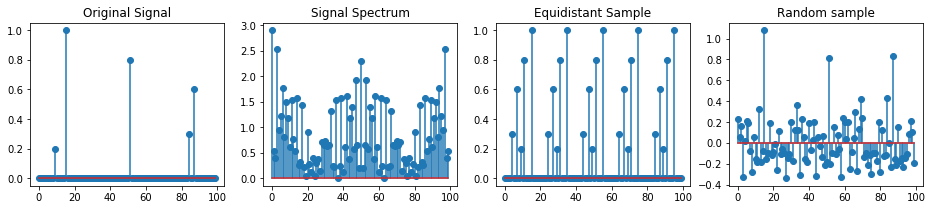

In [2]:
sample_factor = 5
signal_length = 100

x = np.array([0.2, 0.3, 0.6, 0.8, 1.0] + [0]*(signal_length-5))
np.random.seed(42)
np.random.shuffle(x)

X = np.fft.fft(x)
Xu = np.zeros(signal_length, dtype='complex')
Xu[::sample_factor] = X[::sample_factor]
Xr = np.zeros(signal_length, dtype='complex')
sample_idx = np.random.choice(signal_length, int(signal_length/sample_factor))
Xr[sample_idx] = X[sample_idx]

xu = np.fft.ifft(Xu) * sample_factor
xr = np.fft.ifft(Xr) * sample_factor

fig, ax = plt.subplots(1, 4, figsize=(16, 3))
ax[0].stem(x)
ax[0].set_title('Original Signal')
ax[1].stem(np.abs(X.real))
ax[1].set_title('Signal Spectrum')
ax[2].stem(xu.real)
ax[2].set_title('Equidistant Sample')
ax[3].stem(xr.real)
ax[3].set_title('Random sample')

In [7]:
def soft_thresh(y, t):
    x_hat = (y/np.abs(y)) * np.maximum(np.abs(y)-t,0)
    return x_hat

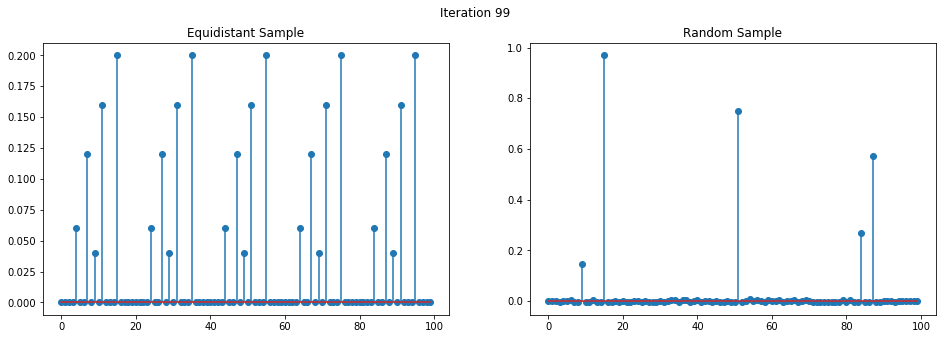

In [4]:
lamda = 0.01
iteration_num = 100

Y1 = Xu
Y2 = Xr
Xi1 = Y1
Xi2 = Y2

for i in range(iteration_num):
    xi1 = np.fft.ifft(Xi1)
    xi1_st = soft_thresh(xi1.real, lamda)
    Xi1 = np.fft.fft(xi1_st)
    Xi1 = Xi1 * (Y1==0) + Y1
    
    xi2 = np.fft.ifft(Xi2)
    xi2_st = soft_thresh(xi2.real, lamda)
    Xi2 = np.fft.fft(xi2_st)
    Xi2 = Xi2 * (Y2==0) + Y2
    
    plt.close()
    fig, ax = plt.subplots(1,2,figsize=(16,5))
    ax[0].stem(xi1.real)
    ax[0].set_title('Equidistant Sample')
    ax[1].stem(xi2.real)
    ax[1].set_title('Random Sample')
    plt.suptitle('Iteration %d' % i)
    display.display(plt.gcf())
    display.clear_output(wait=True)

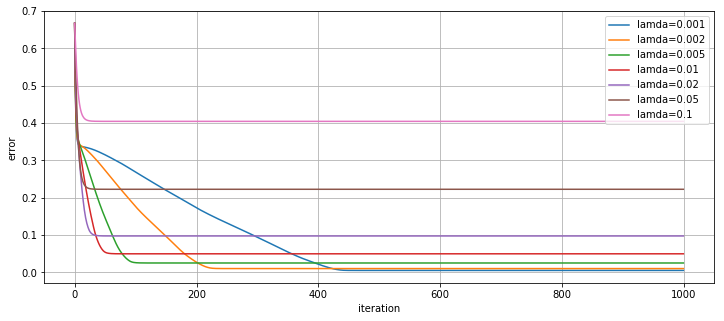

In [5]:
lamda_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]

plt.figure(figsize=(15,5))
for lamda in lamda_values:
    Y1 = Xu
    Y2 = Xr
    Xi1 = Y1
    Xi2 = Y2

    history = []
    for _ in range(1000):
        xi1 = np.fft.ifft(Xi1)
        xi1_st = soft_thresh(xi1.real, lamda)
        Xi1 = np.fft.fft(xi1_st)
        Xi1 = Xi1 * (Y1==0) + Y1

        xi2 = np.fft.ifft(Xi2)
        xi2_st = soft_thresh(xi2.real, lamda)
        Xi2 = np.fft.fft(xi2_st)
        Xi2 = Xi2 * (Y2==0) + Y2

        error = np.abs(np.linalg.norm(x) - np.linalg.norm(xi2.real))/np.linalg.norm(x)
        history.append(error)
    
    plt.plot(history, label='lamda={}'.format(lamda))
    
plt.xlabel('iteration')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid('on')    

In [4]:
brain = Image.open('brain_mri.jpeg')
brain_array = np.array(brain)
brain_fourier = np.fft.fft2(brain_array)
brain_fourier_shift = np.fft.fftshift(brain_fourier)
brain_fourier_powerspect = np.abs(brain_fourier_shift) ** 2

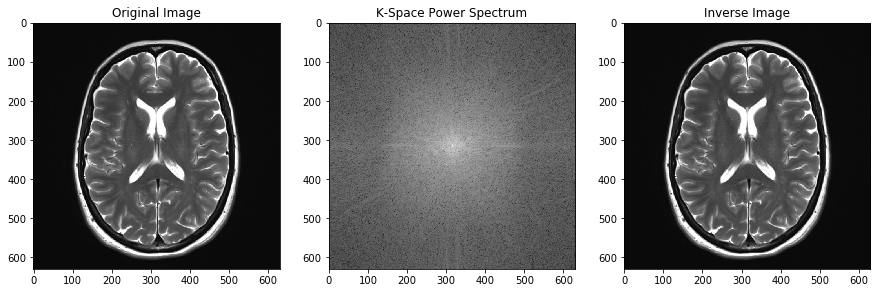

In [5]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(brain_array, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(np.log10(brain_fourier_powerspect), cmap='gray')
ax[1].set_title('K-Space Power Spectrum')
ax[2].imshow(np.fft.ifft2(brain_fourier).real, cmap='gray')
ax[2].set_title('Inverse Image')

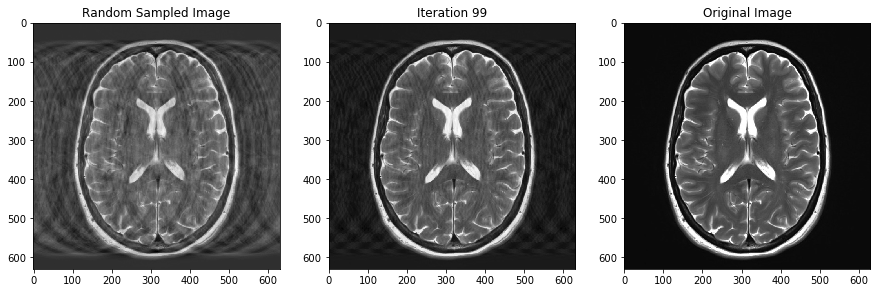

In [11]:
lamda = 1.0
iteration_num = 100

brain_under = np.zeros(brain_fourier.shape, dtype='complex')

p = 0.70
np.random.seed(42)
mask = np.random.binomial(1, p, size=brain_fourier.shape[0]).astype(np.bool)
brain_under[:,mask] = brain_fourier_shift[:,mask]
brain_under = np.fft.ifftshift(brain_under)
brain_rec = np.fft.ifft2(brain_under)

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(brain_rec.real, cmap='gray')
ax[0].set_title('Random Sampled Image')
ax[2].imshow(brain_array, cmap='gray')
ax[2].set_title('Original Image')

Y = brain_under
Xi = Y

for i in range(iteration_num):
    xi =np.fft.ifft2(Xi)
    xi_st = soft_thresh(xi.real, lamda)
    Xi = np.fft.fft2(xi_st)
    Xi = Xi * (Y==0) + Y
    
    ax[1].imshow(xi.real, cmap='gray')
    ax[1].set_title('Iteration %d' % (i))
    display.display(plt.gcf())
    display.clear_output(wait=True)

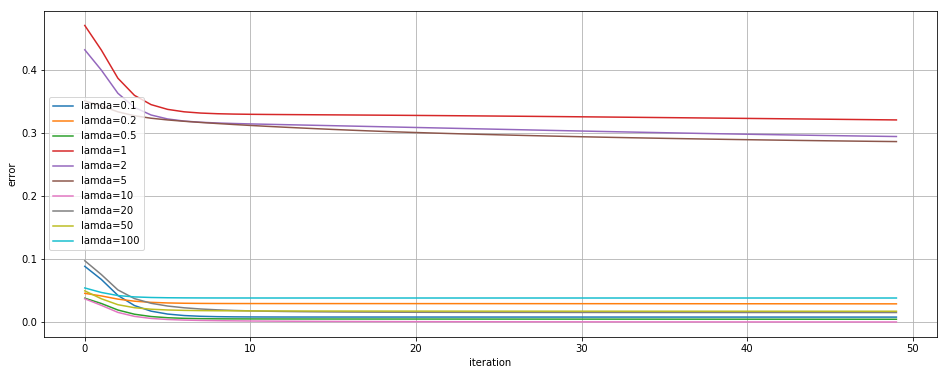

In [14]:
lamda_values = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
iteration_num = 50

p = 0.70
np.random.seed(42)

plt.figure(figsize=(16,6))
for lamda in lamda_values:
    
    brain_under = np.zeros(brain_fourier.shape, dtype='complex')
    mask = np.random.binomial(1, p, size=brain_fourier.shape[0]).astype(np.bool)
    brain_under[:,mask] = brain_fourier_shift[:,mask]
    brain_under = np.fft.ifftshift(brain_under)
    brain_rec = np.fft.ifft2(brain_under)

    Y = brain_under
    Xi = Y

    history = []
    for i in range(iteration_num):
        xi =np.fft.ifft2(Xi)
        xi_st = soft_thresh(xi.real, lamda)
        Xi = np.fft.fft2(xi_st)
        Xi = Xi * (Y==0) + Y
    
        error = np.abs(np.linalg.norm(brain) - np.linalg.norm(xi)) / np.linalg.norm(brain)
        history.append(error)
        
    plt.plot(history, label='lamda={}'.format(lamda))
    
plt.xlabel('iteration')
plt.ylabel('error')
plt.legend(loc='best')
plt.grid('on')       